In [1]:
# NOTEBOOK IMPORTS
import os, glob, warnings, pickle, re
import numpy as np
from shutil import copyfile, rmtree
from datetime import datetime
from fuzzywuzzy import process

# IMAGE IMPORTS
from PIL import Image
import cv2

# GIS IMPORTS
from affinetransformation import *
from affine import Affine
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, LineString, Point, MultiPoint, box
import rasterio as rio
import contextily as cx

# IMAGE IMPORTS
from skimage.morphology import skeletonize
from skimage import img_as_bool, img_as_ubyte


# PLOTTING IMPORTS
import matplotlib.pyplot as plt

# CUSTOM UTILITIES
from IndexUtils import * 
from TileUtils import *

# TILED INFERENCE
import sahi
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction, predict
sahi.utils.cv.IMAGE_EXTENSIONS = ['.jpg', '.jpeg', '.png', '.tiff', '.bmp', '.tif']

Image.MAX_IMAGE_PIXELS = 933120000
warnings.filterwarnings("ignore")
initialize = False

%matplotlib widget

WARNING  Python>=3.10 is required, but Python==3.8.18 is currently installed 


IO directories depending on which machine. 

In [2]:
username = os.getlogin()

dnn_params = {}
dnn_params['CLNN'] = {}
dnn_params['TPNN'] = {}
dnn_params['RLNN'] = {}
dnn_params['FLNN'] = {}
dnn_params['TLNN'] = {}


if username == 'fhacesga':
    base_input_path   = r"D:\RECTDNN\Uncompress\\"
    base_output_path  = r"D:\RECTDNN\processing\\"
    ref_dir  = r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\\"
elif username == 'fhace':
    base_input_path   = r"C:\Users\fhace\Desktop\FIRMs\data\Uncompress\\"
    ref_dir = r"C:\Users\fhace\Desktop\FIRMs\data\AAA_ReferenceDatasets\\"
    base_output_path = r"C:\Users\fhace\Desktop\FIRMs\data\Outputs\\"
    # dnn_params['TLNN']['model_weights']    = r"C:\Users\fhace\Desktop\FIRMs\data\BBNN\curr_weights.pt"
    dnn_params['CLNN']['model_checkpoint'] = r"C:\Users\fhace\Desktop\FIRMs\data\RLNN\checkpoint_101423.pth"
    dnn_params['TPNN']['model_checkpoint'] = r"C:\Users\fhace\OneDrive - University Of Houston\AAA_RECTDNN\data\TPNN\checkpoint_091523_pyramids_2.pth"
    dnn_params['RLNN']['model_checkpoint'] = r"C:\Users\fhace\OneDrive - University Of Houston\AAA_RECTDNN\data\RLNN\checkpoint_091323.pth"
    
else:
    base_input_path   = r"D:\Desktop\FIRMsDigitizing\data\HistoricalFIRMS"
    base_output_path  = r"D:\Desktop\FIRMsDigitizing\processing"
    ref_dir  = r"C:\Users\franc\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\\"

if not initialize:
    initialize = init_databases(ref_dir)

Create working dir and unzip all files if needed

In [3]:
# MAKE PROCESSING DIRECTORY
# datetime_str = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# proc_dir     = os.path.join(base_output_path, datetime_str)
proc_dir = r"D:\RECTDNN\processing\2024-10-11_15-08-46\\"

# IF THERE ARE ANY ZIP FILES IN DIRECTORY, UNZIP THEM IN PLACE
if len(glob.glob(base_input_path + "*.zip*")) != 0:
    extractZipFiles(base_input_path, base_input_path)

outputs_dir  = os.path.join(proc_dir, "Outputs")
os.makedirs(outputs_dir, exist_ok=True)

Read through all the images in the directory. Some images are saved as Multi-page TIFF files. These need to be exported into individual images. We'll do that first in-place at uncompressed directory

In [4]:
remove_files = []

for filename in tqdm(glob.glob(base_input_path + "\\*.tif*")):
    tiff_file = os.path.join(base_input_path, filename)
    try:
    # Check if the file is a multi-page TIFF
        with Image.open(tiff_file) as img:
            if img.is_animated:    
                print(f"Expanding {os.path.basename(tiff_file)} into {img.n_frames}")
                for i in range(img.n_frames):
                    try:
                        img.seek(i)
                        output_filename = f"{os.path.splitext(tiff_file)[0]}_{i+1}{os.path.splitext(tiff_file)[1]}"
                        img.save(output_filename, format=img.format)
                    except:
                        print(f"Error with {tiff_file} page {i}")
                        continue
                remove_files.append(tiff_file)
    except Exception as e:
        print(f"Error opening {tiff_file}")
        print(e)
        continue

for tiff_file in remove_files:
    os.remove(tiff_file)

  0%|          | 0/1706 [00:00<?, ?it/s]

Error opening D:\RECTDNN\Uncompress\485479B.tif
cannot identify image file 'D:\\RECTDNN\\Uncompress\\485479B.tif'
Error opening D:\RECTDNN\Uncompress\485479C.tif
cannot identify image file 'D:\\RECTDNN\\Uncompress\\485479C.tif'
Error opening D:\RECTDNN\Uncompress\485481A.tif
cannot identify image file 'D:\\RECTDNN\\Uncompress\\485481A.tif'
Error opening D:\RECTDNN\Uncompress\485510.tif
cannot identify image file 'D:\\RECTDNN\\Uncompress\\485510.tif'
Error opening D:\RECTDNN\Uncompress\485510B.tif
cannot identify image file 'D:\\RECTDNN\\Uncompress\\485510B.tif'
Error opening D:\RECTDNN\Uncompress\485514B.tif
cannot identify image file 'D:\\RECTDNN\\Uncompress\\485514B.tif'
Error opening D:\RECTDNN\Uncompress\485516A.tif
cannot identify image file 'D:\\RECTDNN\\Uncompress\\485516A.tif'


Here we're using heuristics to identify indices within all the image files. These include:
- Files that are shorter than 12 characters
- Files that have the ```IND``` marker

We create a Pandas DataFrame with the files matching. We then add several fields as below

In [5]:
# LIST ALL IMAGES IN DIRECTORY
image_files = glob.glob(f"{base_input_path}/*")

# FILTER IMAGES USING HEURISTICS
patterns = ["IND", "_1."]
index_files = [file for pattern in patterns for file in glob.glob(base_input_path + "\\*" + pattern + "*")]
filtered_files = [file for file in image_files if len(os.path.basename(file)) < 12]
index_files.extend(filtered_files)

# CREATE DATAFRAME
index_files = pd.DataFrame(index_files, columns=["FilePath"])

# INDEX ATTRIBUTES TO BE ADDED
index_files["Basename"] = [os.path.basename(file) for file in index_files["FilePath"].to_list()]    # BASENAME
index_files["Location"] = index_files["Basename"].apply(extract_numerical_chars).astype(np.int32)   # 
index_files["GEOID"]    = index_files["Location"].apply(getGEOID)       # GET GEOID FOR EACH INDEX
index_files["geometry"] = index_files["GEOID"].apply(getGeometry)       # GET GEOMETRY FROM MATCHING GEOIDs

This is where we perform the ICP for each index...

In [6]:
verbose = True

# TPNN = None
RLNN = None
CLNN = None

# THIS CHECKS WHETHER THE RUN WAS INTERRUPTED
# TO MAKE SURE WE'RE NOT STARTING FROM SCRATCH UNNECESSARILY
try:
    gen_dict
    print("Starting with predefined dict")
except:
    gen_dict = {}

# OUTPUT DIRECTORY FOR GENERAL RESULTS STRUCTURE
output_struct_dir = os.path.join(outputs_dir, "IndexCoords.pkl")

if not os.path.exists(output_struct_dir):
    for i, row in tqdm(index_files.iterrows(), total=index_files.shape[0]):
        
        try:

            filename = os.path.basename(row["FilePath"])
            
            # THIS CHECKS WHETHER THIS PARTICULAR RASTER WAS RUN ALREADY BY USING THE INDIVIDUAL PKL FILE
            if os.path.exists(os.path.join(outputs_dir, f"{filename}.pkl")):
                print(f"Skipping, found {os.path.join(outputs_dir, filename + '.pkl')}")
                continue

            # READ FILES AND CONVERT TO GRAYSCALE
            image = cv2.imread(row["FilePath"])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image_arry = np.asarray(image)
            
            # SAVE IMAGE TO OUTPUT DIRECTORY
            output_image_fn = os.path.join(outputs_dir, filename.split(".")[0] + ".tif")
            copyfile(row["FilePath"], output_image_fn)

            # GET BOUNDARY POINTS FROM RESPECTIVE SHAPEFILE
            output = getBoundaryPoints(row, distance=100) # TODO: THIS IS THE SAME AS OUR APPROX ACCURACY - MAYBE MAKE IT TIGHTER? 
            if output is None:
                print(f"COULD NOT FIND SHAPEFILE FOR {filename}")
                continue
            point_boundary_gdf, shp_bounds = output
            
            # RUN IMAGES THROUGH DNNs
            classifications, TPNN  = findKeypoints(image, model=TPNN, **dnn_params['TPNN'])
            effectiveArea, RLNN    = findSquares(image, model=RLNN, **dnn_params['RLNN'])
            countyArea, CLNN       = findCounty(image, model=CLNN, **dnn_params['CLNN'])
            tiles, TLNN            = runTLNN(row['FilePath'])

            dnn_outputs = {
                "classifications"   : classifications,
                "effectiveArea"     : effectiveArea,
                "countyArea"    : countyArea,
                "tiles"         : tiles
            }
            
            # GET COUNTY BOUNDS IDENTIFIED IN INDEX BY TLNN
            # bounds_panels = tiles["county"]["bbox"]
            bounds_panels = find_bbox(dnn_outputs['countyArea'][:, :, 1])

            # SKIP IF WE CAN'T FIND BOUNDARY IN EXISTING DATABASES
            if point_boundary_gdf is None:
                continue

            # DEFINE BOUNDARY STRUCTU
            boundaries = {
                "point_boundary_gdf"    : point_boundary_gdf,
                "shp_bounds"            : shp_bounds,
                "bounds_panels"         : bounds_panels,
            }

            # WHAT ARE WE LOOKING FOR IN EACH IDENTIFIED SQUARE?
            key = findKey(row["Basename"])    
            if key is None:
                print(f"Could not find key in {filename}")
            
            # DO ICP
            transform_dict = performICPonIndex(boundaries, dnn_outputs, debug=False, plot=False, rotation=True, shear=False, perspective=False, icp_iterations=30)

            # GET TRANSFORM FROM ICP TO CRS TRANSFORM
            output_transform, transform_dict = ICPtoCRSTransform(image_arry, transform_dict)

            # GET OUTPUT TRANSFORM INTO AFFINE AND WRITE
            output_affine = Affine(*output_transform.flatten()[:6])
            with rio.open(output_image_fn, 'w',
                driver='GTiff',
                height=image.shape[0], width=image.shape[1],
                count=1, dtype=image.dtype,
                crs=f'EPSG:3857',
                transform=rio.Affine(*output_transform.flatten()[:6])) as dst:
                    dst.write(image, 1)   

            tiles['transform_info'] = transform_dict
            tiles['output_transform'] = output_transform
            gen_dict[filename] = tiles

            with open(os.path.join(outputs_dir, f"{filename}.pkl"), 'wb') as handle:
                pickle.dump(gen_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        except:
            print(f'Error with {os.path.basename(row["FilePath"])}')
            continue
    
    # SAVE AS GENERAL OUTPUT
    with open(os.path.join(outputs_dir, "IndexCoords.pkl"), 'wb') as handle:
        pickle.dump(gen_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(output_struct_dir, 'rb') as f:
        gen_dict = pickle.load(f)

In [32]:
gen_dict['48201CIND0_0992.tif']['tile'][0]['data']


import easyocr


error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'cvtColor'
> Overload resolution failed:
>  - src data type = 0 is not supported
>  - Expected Ptr<cv::UMat> for argument 'src'


In [39]:
reader = easyocr.Reader(['en']) # this needs to run only once to load the model into memory


{'bbox': array([      10788,      6057.8,       12051,      7014.2]),
 'data': <PIL.Image.Image image mode=1 size=1263x957>,
 'text': 'City of\n\n\\:\n\nBAY\n\nHouston\n\nAN\n\n\\\n\nSAN JACINTO\n\nA\n\nA\n\n\\\n\nR\n\n&\n\nA\n\ne\n\n\\\n\nZ\n\n¢\n\nA\\\n\n\\\n\n\\\n\n%\\\\}\n\nY\n\né\n\nO\n\nv\n\nhEn!\n\neri)\n\nXY\n\n0\n\nm\n\nA\\\n\n)\n\n\\\n\nb\n\n§\n\n.\n\n.\n\n4\n\n-\n\n\\\n\n\\\n\n%\n\nS——— h ASR—\n',
 'keyed_text': None,
 'confidence': 0.9247301}

In [77]:
import re

'485470'

In [89]:
out_dir = r"D:\RECTDNN\TNNN\images\\"

# key = "48201"

unsureCounter = 0

for i, (k, v) in enumerate(gen_dict.items()):
    key = findIndexKey(k)
    for ii, (kk, vv) in enumerate(v['tile'].items()):
        image = np.asarray(vv['data'], dtype=np.uint8)

        if np.max(image) < 255:
            image = image * 255

        texts = reader.readtext(cv2.cvtColor(image, cv2.COLOR_GRAY2BGR), detail=0)
        
        texts = [a for a in texts if len(a) >= len(key)]
        if not len(texts) == 0:
            text, val = process.extractOne(key, texts)
        else: 
            val = 0
        if val < 60:
            text = f"Unsure{unsureCounter}"
            unsureCounter = unsureCounter + 1
        else:
            # text= text.split(" ")[0]
            text = re.sub('[^A-Za-z0-9]+', '', text)
            text = re.sub(f'^.*?{key}', key, text)
            text = text.capitalize()
        
        plt.imsave(os.path.join(out_dir, text) + ".png", image, cmap='Greys_r')

TypeError: join() argument must be str, bytes, or os.PathLike object, not 'builtin_function_or_method'

In [ ]:


for i in range(0, 100):
    texts = reader.readtext(cv2.cvtColor(np.asarray(gen_dict['48201CIND0_0992.tif']['tile'][i]['data'], dtype=np.uint8) * 255, cv2.COLOR_GRAY2BGR), detail=0)
    texts = [a for a in texts if len(a) >= len(key)]
    if not len(texts) == 0:
        text, val = process.extractOne("48201", texts)
    else: 
        val = 0
    if val < 60:
        text=process.extract("48201", texts)
    else:
        text= text.split(" ")[0]
    print(text, gen_dict['48201CIND0_0992.tif']['tile'][i]['keyed_text'])

In [55]:
from fuzzywuzzy import process

[('1', 90), ('482100190', 72), ('(P118-23-00)', 40), ('Tributary 11.96 to', 18), ('Tebntery', 0)]


In [7]:
stateplanes = gpd.read_file(f"{data_dir}/AAA_ReferenceDatasets/stateplane.shp")
intersections = gpd.read_file(f"{data_dir}/AAA_ReferenceDatasets/OSM_Roads/TexasRoads_filtered_strict_3857_nondupe_smaller.gpkg", engine='pyogrio', use_arrow=True)
roads_gdf = gpd.read_file(r"C:\Users\fhacesga\Downloads\TexasRoads_filtered_strict_3857.gpkg", engine='pyogrio', use_arrow=True)
init_databases(f"{data_dir}/AAA_ReferenceDatasets/")

True

Which tiles are we processing?

In [8]:
# LIST ALL IMAGES IN DIRECTORY
image_files = []
wildcards = ['480287', '48201']
for w in wildcards:
    image_files.extend(glob.glob(f"{base_input_path}/*{w}*"))
image_files = [f for f in image_files if 'w' not in os.path.splitext(f)[1]]

# FILTER IMAGES USING HEURISTICS TO GET TILEINDICES
patterns = ["IND", "_1."]
index_files = [file for pattern in patterns for file in glob.glob(base_input_path + "\\*" + pattern + "*.*[!w]*")]
filtered_files = [file for file in image_files if len(os.path.basename(file)) < 12]
index_files.extend(filtered_files)

# GET ACTUAL TILES
tiles       = list(set(image_files) - set(index_files))
tiles_bns   = [os.path.basename(tile).split(".")[0] for tile in tiles]

Build tile database for detections in images

In [9]:
duplicate_db, non_dupped_dict, dupped_dict = buildDetectedDatabase(gen_dict)

print(len(non_dupped_dict), len(dupped_dict))  

detected_tiles = pd.DataFrame.from_dict(non_dupped_dict).T
detected_tiles['geometry'] = detected_tiles['coords'].apply(bbox_to_polygon)
detected_tiles_gdf = gpd.GeoDataFrame(detected_tiles)
detected_tiles_gdf = detected_tiles_gdf[['geometry']]

2190 1493


In [19]:
list(non_dupped_dict.keys())

['4800350350',
 '4800350625',
 '4800350240',
 '4800350275',
 '4800350305',
 '4800350310',
 '4800350195',
 '4800350295',
 '4800350170',
 '4800350315',
 '4800350285',
 '4800350495',
 '4800350165',
 '48003503200',
 '4800350050',
 '480035',
 '4800350380',
 '4800350575',
 '4800350065',
 '4800350650',
 '4800350190',
 '4800350395',
 '4800350485',
 '4800350600',
 '4800350425',
 '4800350330',
 '4800350525',
 '4800350100',
 '4800350180',
 '4800350490',
 '4800350025',
 '4800350225',
 '4800350475',
 '4800350675',
 '4800350375',
 '4800350475_1',
 '4800350450',
 '48003501251',
 '4800350155',
 '4800350160',
 '4800350065_1',
 '4800350250',
 '4800350375_1',
 '4800350240_1',
 '4800350485_1',
 '4800350350_1',
 '4800350305_1',
 '48003501',
 '4800350625_1',
 '4800350250_1',
 '4800350185',
 '4800350315_1',
 '480035049',
 '4800350245',
 '4800350150',
 '4800350050_1',
 '4800350170_1',
 '4800350480',
 '4800350310_1',
 '4800350295_1',
 '48003548003',
 '4800350275_1',
 '4800350125',
 '4800350190_1',
 '4800350600

Supplement tile database with existing world files

In [10]:
fn = os.path.join(proc_dir, "WorldFileDatabase.feather")
if os.path.exists(fn):
    df = pd.read_pickle(fn)
else:
    df = buildWorldFileDatabase(base_input_path, duplicate_db, stateplanes)
    df.to_pickle(fn)

  0%|          | 0/178 [00:00<?, ?it/s]

NO BOUNDS FOUND D:\RECTDNN\Uncompress\48201C0195M.tif
NO CORRESPONDING IMAGE 48201C0295L
NO BOUNDS FOUND D:\RECTDNN\Uncompress\48201C0415M.tif
NO BOUNDS FOUND D:\RECTDNN\Uncompress\48201C0970M.tif
NO BOUNDS FOUND D:\RECTDNN\Uncompress\48201C1030L.tif


Save both databases as shapefiles

In [11]:
# Apply the function to the 'bbox' column
df['geometry'] = df['webmerc'].apply(bbox_to_polygon)
gdf = gpd.GeoDataFrame(df)
gdf.dropna(axis=0)

for key in gdf.keys():
    if key == 'geometry':
        continue
    gdf[key] = gdf[key].astype(str)

gdf.to_file(os.path.join(proc_dir, "WorldFiles.shp"))
detected_tiles_gdf.to_file(os.path.join(proc_dir, "Detected.shp"))

10/17/2024 13:04:54 - WARNING - fiona._env -   Normalized/laundered field name: 'county_polygon' to 'county_pol'
10/17/2024 13:04:54 - WARNING - fiona._env -   Normalized/laundered field name: 'geotransform' to 'geotransfo'
10/17/2024 13:04:54 - WARNING - fiona._env -   Value 'POLYGON ((-10998986.630495073 3442345.1494930303, -10998989.413482342 3443072.7069743867, -10998989.413482342 3443085.244810135, -10998992.419108594 3443907.139235744, -10998992.753067069 3443996.0615163385, -10998992.975706048 3444053.253579455, -10998992.975706048 3444061.9539602045, -10998993.977581466 3444306.974438235, -10998994.979456883 3444558.7809968283, -10998996.649249244 3445009.9466724684, -10998998.096402625 3445407.384719966, -10998998.207722114 3445427.0905944975, -10998998.430361098 3445557.6107811993, -10998998.430361098 3445561.1937068603, -10998998.430361098 3445577.7007700475, -10998998.430361098 3445582.5633198093, -10998999.766194988 3445827.100745894, -10999001.65862633 3446393.7389890878,

For each image we are processing, identify street corners

In [16]:
half_path = os.path.join(proc_dir, "half_size")
yolo_path = os.path.join(proc_dir, "street_corners")

os.makedirs(half_path, exist_ok=True)
os.makedirs(yolo_path, exist_ok=True)

streetcorner_out_fn = os.path.join(proc_dir, "streetcorners.pkl")

if not os.path.exists(streetcorner_out_fn):
    print("Processing images from scratch")

    # NEED TO MAKE THEM HALF RESOLUTION
    processing_images=[]
    for tile in tqdm(tiles):
        half_out_fn = os.path.join(half_path, os.path.basename(tile))
        processing_images.append(half_out_fn)
        if not os.path.exists(half_out_fn):
            a    = cv2.imread(tile)
            half = cv2.resize(a,  (0, 0), fx=0.5, fy=0.5)
            cv2.imwrite(half_out_fn, half)

    detection_model = AutoDetectionModel.from_pretrained(
        model_type="yolov8",
        model_path=r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\FANN\FANN_large_YOLO.pt",
        confidence_threshold=0.3,
        device="cuda",  # or 'cuda:0'
    )
    
    result = predict(source=half_path, # source=processing_images[0], # source=half_path, 
                    detection_model=detection_model, 
                    verbose=2, 
                    project=yolo_path,
                    slice_height=256, 
                    slice_width=256, 
                    model_device="cuda", 
                    return_dict=True, 
                    export_pickle=True,
                    visual_hide_labels=True)

    def get_largest_subdirectory(base_dir):
        subdirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
        numbered_subdirs = [(d, int(d.replace('exp', ''))) for d in subdirs if d.startswith('exp') and d[3:].isdigit()]
        largest_subdir = max(numbered_subdirs, key=lambda x: x[1])[0] if numbered_subdirs else None
        return os.path.join(base_dir, largest_subdir)

    pkldir    = os.path.join(get_largest_subdirectory(yolo_path), "pickles\\")
    print(f"Reading results from: {pkldir}" )

    pkl_files = glob.glob(pkldir + "*")

    streetcorner_dict = {}

    for pkl in pkl_files:
        with open(pkl, 'rb') as f:
            x = pickle.load(f)

        streetcorner_dict[os.path.basename(pkl)] = np.array([calcCenter(a.bbox.to_xyxy()) for a in x])

    pickle.dump(streetcorner_dict, open(streetcorner_out_fn, "wb" ) )
else:
    streetcorner_dict = pickle.load(open(streetcorner_out_fn, "rb"))

In [19]:
'''FANN_prior = None
RLNN_prior = None
model = None

color=False

plot_params = {"labels" : False, }
YOLO_params = {
    "device"  : "cuda",     "find_text" : False, 
    "keyed_text"  : False,  "verbose" : False,  "get_data"  : False,
    "target_size" : 1920,   "plot_params" : plot_params, "ret_values" : True
}

# IF WE'VE ALREADY STARTED PROCESSING THINGS, LOAD STATE DICT
if os.path.exists(f'{proc_dir}results.pkl'):
    print("FOUND DICTIONARY, LOADING")
    with open(f'{proc_dir}results.pkl', 'rb') as handle:
        results_struct = pickle.load(handle)
else:
    results_struct = {}

# LOOP FOR EACH TILE
for i, tile in tqdm(enumerate(tiles), total=len(tiles)):
    
    # DEFINE WHERE GEOREFERENCED TILE IS SAVED
    out_fn = os.path.join(proc_dir, os.path.basename(tile).split(".")[0] + "_FANN.png")
    fin_fn = os.path.join(proc_dir, os.path.basename(tile).split(".")[0] + "_results.pkl")

    # HAVE WE ALREADY PROCESSED THIS TILE? IF SO, SKIP
    if results_struct.get(tile, None):
        # print(f"Found in dict, skipping {tile}")
        continue

    # WHICH VERSION OF FANN ARE WE USING
    if color:
        # RUN AND SAVE PREPROCESSING FANN AND RLNN
        prepped_fn = os.path.join(proc_dir, os.path.basename(tile).split(".")[0] + "_prepped.png")                      # FILE NAME
        prepped, FANN_prior, RLNN_prior, bounds = findStreetCorners_colorPrep(tile, FANN=FANN_prior, RLNN=RLNN_prior)   # RUN FANN_PRIOR AND RLNN
        Image.fromarray(prepped).save(prepped_fn) # SAVE

        # RUN FANN
        results, model, base = runYOLO_Text(prepped_fn, model=model, model_weights=f"{data_dir}FANN/YOLO/051624.pt", **YOLO_params)
        
    else:
        bounds = None

        # RUN FANN
        results, model, base = runYOLO_Text(tile, model=model, model_weights=f"{data_dir}FANN/YOLO/051624_bw.pt", **YOLO_params)

    results_struct[tile] = results
    
    '' IF YOU WANT TO SAVE DETAILED OUTPUT, THIS CODE WORKS, BUT IT'S HELLA SLOW AND BURDENSOME
    temp_dict = {"results" : results, "bounds" : bounds, "results_2" : base}
    results_struct[tile] = fin_fn
    if os.path.exists(fin_fn):
        os.remove(fin_fn)
    with open(fin_fn, 'wb') as handle:
        pickle.dump(temp_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    ''

    
    # SAVE EVERY N ITERATIONS AND LAST
    if i % 60 == 0 or i == len(tiles) - 1:
        file_path = f'{proc_dir}results.pkl'
        if os.path.exists(file_path):
            os.remove(file_path)
        with open(file_path, 'wb') as handle:
            pickle.dump(results_struct, handle, protocol=pickle.HIGHEST_PROTOCOL)
    '''

'FANN_prior = None\nRLNN_prior = None\nmodel = None\n\ncolor=False\n\nplot_params = {"labels" : False, }\nYOLO_params = {\n    "device"  : "cuda",     "find_text" : False, \n    "keyed_text"  : False,  "verbose" : False,  "get_data"  : False,\n    "target_size" : 1920,   "plot_params" : plot_params, "ret_values" : True\n}\n\n# IF WE\'VE ALREADY STARTED PROCESSING THINGS, LOAD STATE DICT\nif os.path.exists(f\'{proc_dir}results.pkl\'):\n    print("FOUND DICTIONARY, LOADING")\n    with open(f\'{proc_dir}results.pkl\', \'rb\') as handle:\n        results_struct = pickle.load(handle)\nelse:\n    results_struct = {}\n\n# LOOP FOR EACH TILE\nfor i, tile in tqdm(enumerate(tiles), total=len(tiles)):\n    \n    # DEFINE WHERE GEOREFERENCED TILE IS SAVED\n    out_fn = os.path.join(proc_dir, os.path.basename(tile).split(".")[0] + "_FANN.png")\n    fin_fn = os.path.join(proc_dir, os.path.basename(tile).split(".")[0] + "_results.pkl")\n\n    # HAVE WE ALREADY PROCESSED THIS TILE? IF SO, SKIP\n    if

54


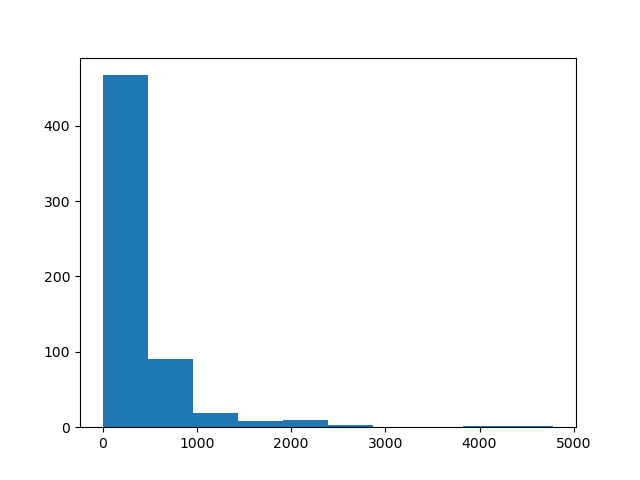

In [22]:
plt.figure()
amount_of_corners = np.array([len(a) for a in streetcorner_dict.values()])
_ = plt.hist(amount_of_corners)
print(np.count_nonzero(amount_of_corners <= 10))

In [23]:
def bboxTransformToCRS(transform, image):
    rev_y_axis = np.array([[1, 0, 0],
                        [0,-1, 0],
                        [0, 0, 1]])
    
    translation = np.eye(3)
    translation[1, 2] = image.shape[0]

    return transform @ translation @ rev_y_axis


def bbox_to_coords_realworld(bbox):
    # BOUNDING BOX 

    x_min, y_min, x_max, y_max = bbox

    xs = [x_min, x_min, x_max, x_max]
    ys = [y_max, y_min, y_min, y_max]
    return xs, ys

def bbox_to_coords_raster(bbox):
    # BOUNDING BOX 

    x_min, y_min, x_max, y_max = bbox

    xs = [x_min, x_min, x_max, x_max]
    ys = [y_min, y_max, y_max, y_min]
    return xs, ys

bad = 0
RLNN = None

tile_coords = {}
debug_struct = {}

referencing_dir = os.path.join(proc_dir, "referencing")
os.makedirs(referencing_dir, exist_ok=True)

detected_tiles['reference_name'] = detected_tiles.index
list_tiles = list(detected_tiles_gdf.index)

# THERE'S AN ISSUE WITH PERFECT MATCHES ON SHORTER STRINGS. 
# (IE 48035 PERFECT FOR 48035001A, WHEN WE'RE LOOKING FOR 48035001)
# TO DEAL WITH IT, WE ONLY COMPARE AGAINST STRINGS OF A CERTAIN LENGTH 
# (SEE HEURISTICALLY-DETERMINED COMP_LENGTH BELOW)
# THIS STRUCTURE CONTAINS ALL POSSIBLE LENGTHS NEEDED, 
# SAVING APPROX 33% TIME INSTEAD OF DYNAMICALLY SHORTENING ALL STRINGS
curr_tile_name_length_dict = {}
bn_lengths = np.array([len(a) for a in tiles_bns])              # LENGTH OF BASENAMES FOR ALL TILES BEING USED
for i in range(np.min(bn_lengths) - 3, np.max(bn_lengths+3)):   # FOR A RANGE AROUND THAT BASE LENGTH
    curr_tile_name_length_dict[i] = [a if i <= len(a) else "" for a in list_tiles]

for i, tile in tqdm(enumerate(tiles), total=len(tiles)):

    comp_length = len(tiles_bns[i]) - 2

    # KEEP NUMERIC PART OF TILE NAME
    p = re.sub(r"[^0-9]", "", os.path.basename(tile))

    # PERFORM MATCHING
    match, score = process.extractOne(tiles_bns[i], curr_tile_name_length_dict[comp_length])
    matches = process.extract(tiles_bns[i], curr_tile_name_length_dict[comp_length])
    out_fn = os.path.join(referencing_dir, tiles_bns[i] + ".tif")
    
    if score >= 90:
        image = np.asarray(Image.open(tile))

        # IF IMAGE IS NOT UINT8, CONVERT
        if np.max(image) < 255:
            image = image * 255
            image = image.astype(np.uint8)

        tile_coords[out_fn] = detected_tiles.loc[match]
        tile_coords[out_fn]['input_file'] = tile

        bounds, RLNN = findBounds(tile, RLNN)
        
        if len(bounds[0]) < 1:
            print(f"COULD NOT FIND BOUNDS, USING IMAGE EXTENTS {tile}")
            
            bbox = [0, 0, image.shape[0], image.shape[1]]
        else:
            bbox = bounds[0].boxes.xyxy.numpy().astype(np.int32)[0].flatten()
        
        real_x, real_y = bbox_to_coords_realworld(tile_coords[out_fn]["coords"])
        pic_x, pic_y   = bbox_to_coords_raster(bbox)

        affine = affineTransformation(pic_x, pic_y, real_x, real_y)
        transform = bboxTransformToCRS(affine.matrix, image)

        debug_struct[out_fn] = {
            "match"  : match,  "basename" : tiles_bns[i],
            "matches": matches, "bbox" : bbox,
            "real_x" : real_x, "real_y" : real_y,
            "pic_x"  : pic_x,  "pic_y"  : pic_y,
            "affine" : affine, "transform" : transform
        }
        try:
            with rio.open(out_fn, 'w',
                driver='GTiff', count=1, dtype=image.dtype,
                height=image.shape[0], width=image.shape[1],
                crs=f'EPSG:3857',
                transform=rio.Affine(*transform.flatten()[:6])) as dst:
                    dst.write(image, 1) 
        except: 
            print(f"Could not save {tiles_bns[i]}")
                
    else:
        tile_coords[out_fn] = None
        print(f"Skipping {out_fn}")
        print(matches)
        debug_struct[out_fn] = {
            "match"  : match,  "basename" : tiles_bns[i],
            "matches": matches,
        }
        bad = bad + 1

  0%|          | 0/599 [00:00<?, ?it/s]

Skipping D:\RECTDNN\processing\2024-10-11_15-08-46\\referencing\480287B_2.tif
[('480287_1', 82), ('4802870_1', 78), ('4802870', 75), ('4802870325', 74), ('4802870200', 74)]
Skipping D:\RECTDNN\processing\2024-10-11_15-08-46\\referencing\480287B_45.tif
[('4802870425', 80), ('4802870450', 80), ('4802870475', 80), ('4802870145', 80), ('4802870465', 80)]
Skipping D:\RECTDNN\processing\2024-10-11_15-08-46\\referencing\480287B_25.tif
[('4802870325', 80), ('4802870425', 80), ('4802870525', 80), ('4802870250', 80), ('4802870225', 80)]
Skipping D:\RECTDNN\processing\2024-10-11_15-08-46\\referencing\480287B_34.tif
[('4802870345', 80), ('4802870340', 80), ('48028703', 78), ('480287_1', 78), ('4802870_1', 74)]
Skipping D:\RECTDNN\processing\2024-10-11_15-08-46\\referencing\480287B_53.tif
[('4802870530', 80), ('48028703', 78), ('480287_1', 78), ('48028705360', 76), ('480287165', 74)]
Skipping D:\RECTDNN\processing\2024-10-11_15-08-46\\referencing\480287B_16.tif
[('480287_1', 89), ('480287165', 84),

  0%|          | 0/300 [00:00<?, ?it/s]

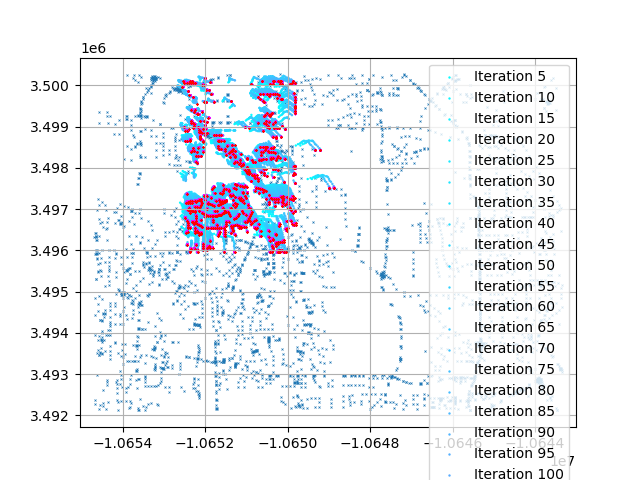

10/17/2024 16:55:43 - INFO - rasterio._env -   GDAL signalled an error: err_no=1, msg='Deleting D:/RECTDNN/processing/2024-10-11_15-08-46/48201C0420M_registered6.tif failed:\nPermission denied'


Could not save photo D:\RECTDNN\processing\2024-10-11_15-08-46\\referencing\48201C0420M.tif


  0%|          | 0/300 [00:00<?, ?it/s]

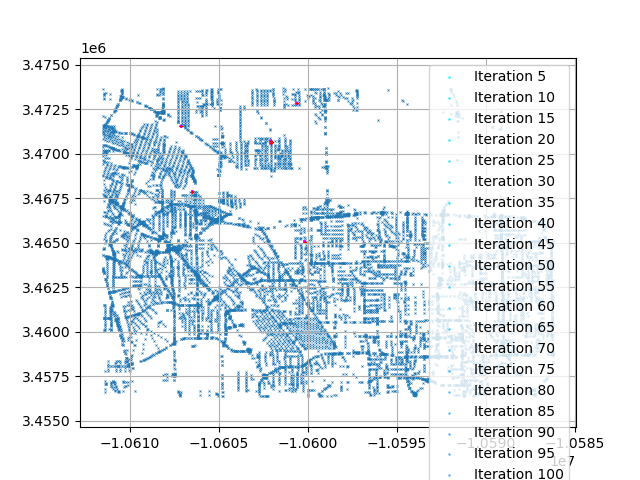

  0%|          | 0/300 [00:00<?, ?it/s]

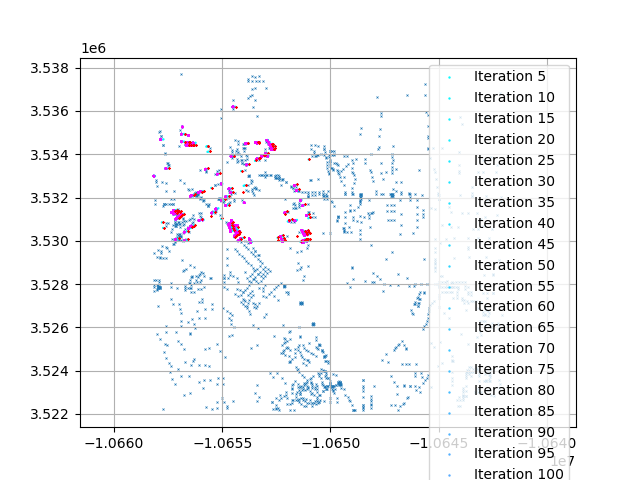

  0%|          | 0/300 [00:00<?, ?it/s]

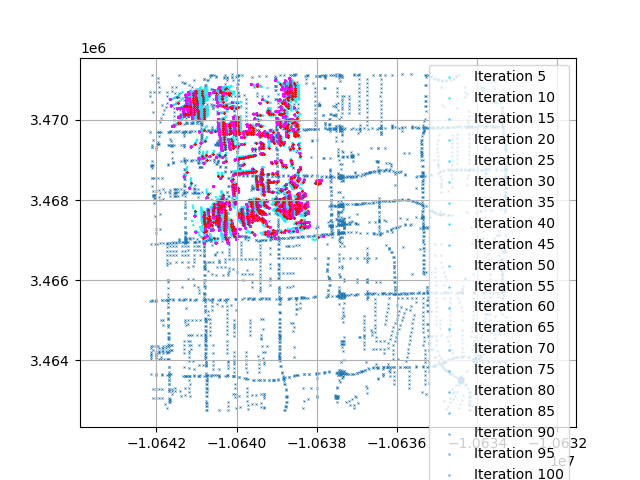

  0%|          | 0/300 [00:00<?, ?it/s]

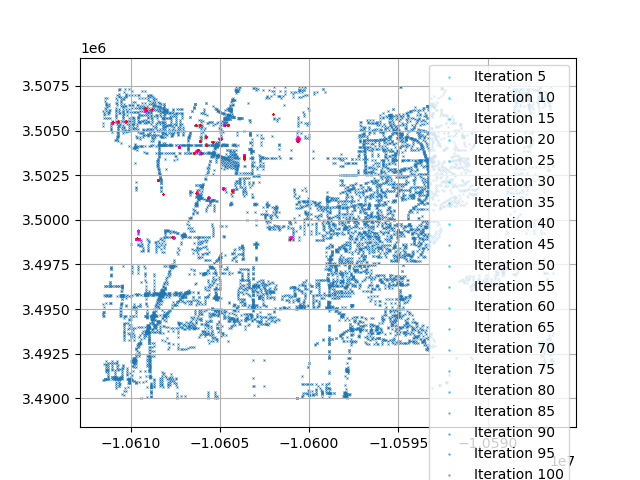

  0%|          | 0/300 [00:00<?, ?it/s]

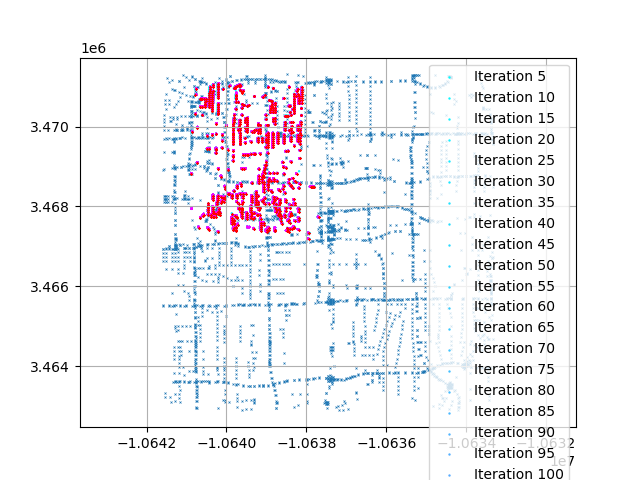

  0%|          | 0/300 [00:00<?, ?it/s]

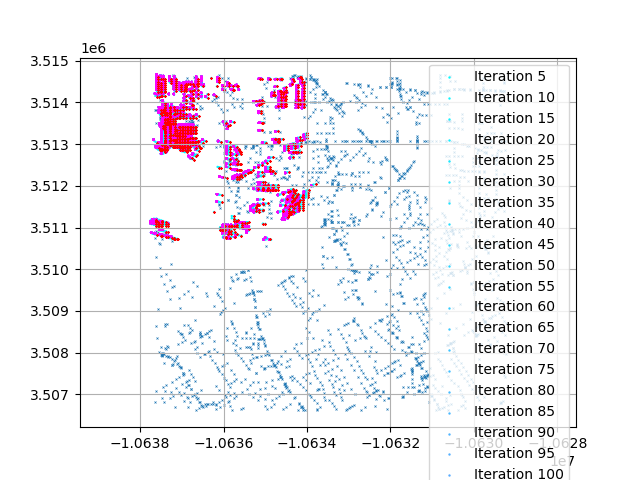

  0%|          | 0/300 [00:00<?, ?it/s]

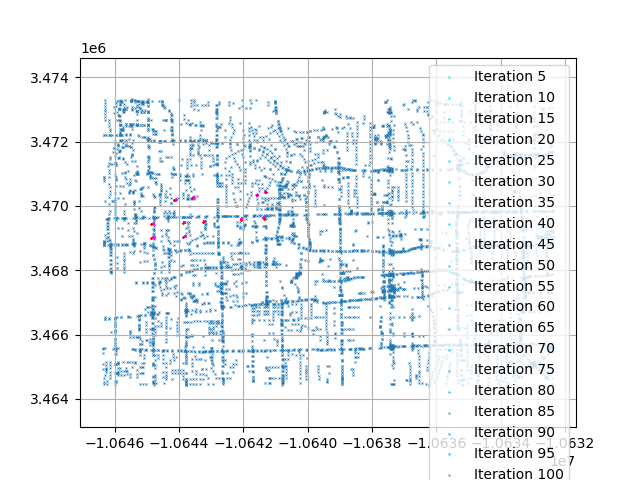

  0%|          | 0/300 [00:00<?, ?it/s]

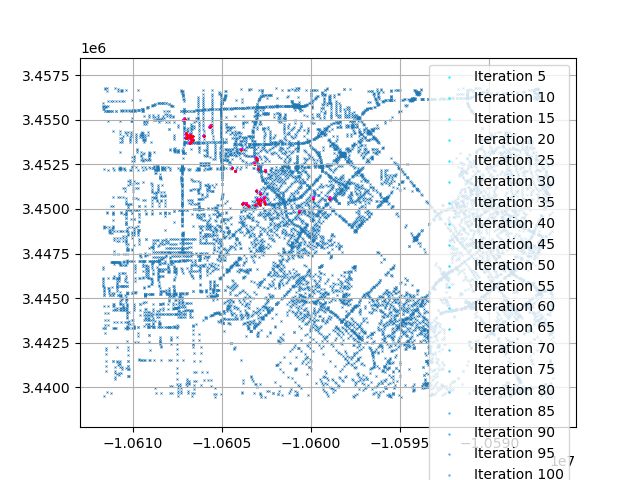

  0%|          | 0/300 [00:00<?, ?it/s]

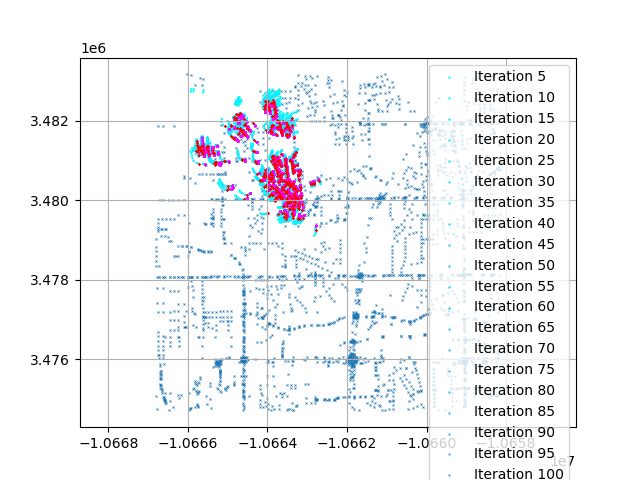

  0%|          | 0/300 [00:00<?, ?it/s]

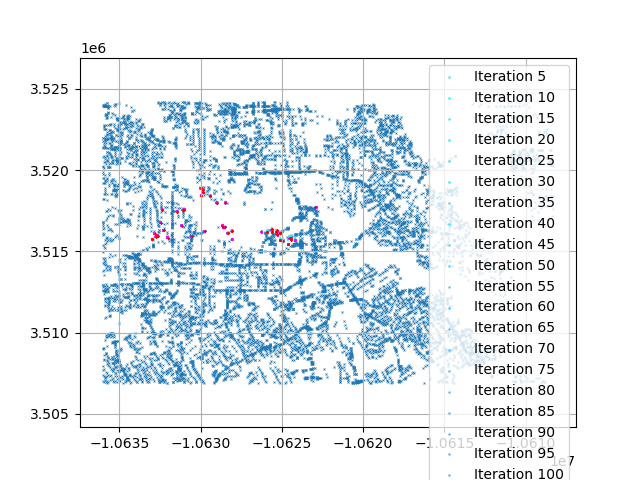

  0%|          | 0/300 [00:00<?, ?it/s]

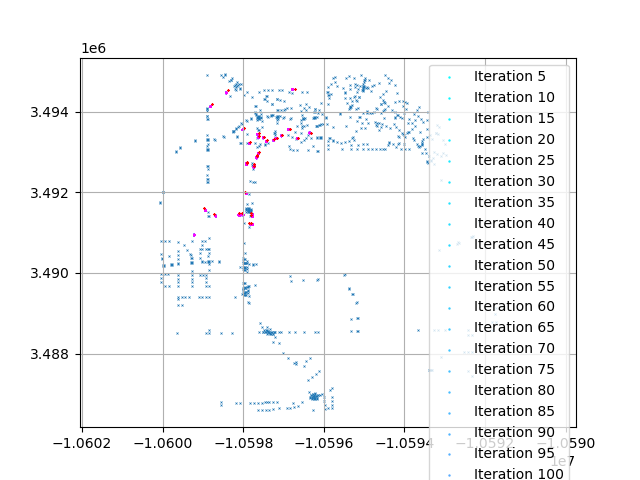

  0%|          | 0/300 [00:00<?, ?it/s]

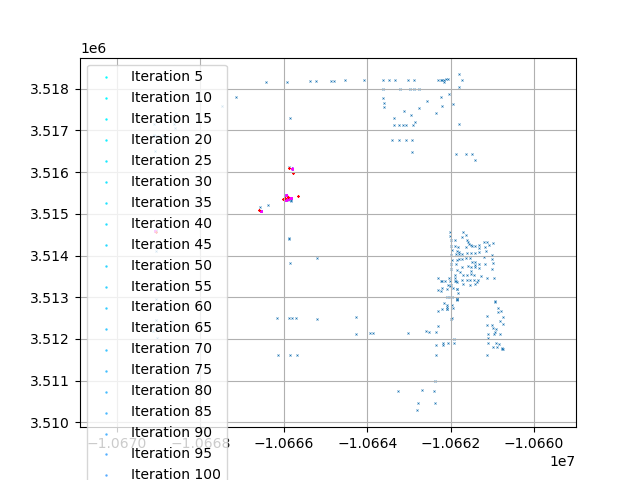

  0%|          | 0/300 [00:00<?, ?it/s]

ValueError: need at least one array to concatenate

In [45]:
bestgrades = []
numcorners = []

allgrades = []

model = TPNN(num_classes=2, finalpadding=1, inputsize=2)
checkpoint = torch.load(r'C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data/FANN/checkpoint_101123.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to('cuda')

for i, (out_name, db) in enumerate(tile_coords.items()):
    if db is not None:

        # try:
        
            # OPEN RASTER AND GET BOUNDING BOX
            ra = rio.open(out_name)
            bounds  = ra.bounds
            image   = ra.read(1)

            # VALID BBOX FOR OBSERVATIONS OF ROADS
            bbox = debug_struct[out_name]['bbox']

            '''
            # RUN ROADS DETECTION ON CNN AND PREP FOR ICP
            roads, _    = split_and_run_cnn(image, model, tilesize=1024, num_dim=3, edges=10, dims_rep=[0], n_pyramids=2, device="cuda", verbose=True)
            roads_thin  = roads[:, :, 1] > 0.95
            roads_thin  = cleanImageBBOX(roads_thin, bbox)
            roads_thin  = skeletonize(roads_thin)    # USE SKELETONIZATION ALGORITHM TO THIN ROADS
            y, x        = np.where(roads_thin[:, :])            # GET X, Y COORDINATES OF IDENTIFIED ROAD POINTS
            street_det  = pointsToGeodataFrame(ra, y, x)        # CONVERT X, Y COORDINATES TO GDF AND REPROEJCT TO CURRENT ESTIMATE OF RASTER POSITION

            # USING CURRENT ENLARGED RASTER EXTENTS, GET RELEVANT ROADS FROM OPENSTREETMAP FILE
            bounds_poly = enlarged_bounds(ra, n=1)              # ENLARGED EXTENTS - NOTE, SET TO 1 (NO ENLARGEMENT) BECAUSE I'M NOT SURE HOW NEEDED THIS IS
            roads_clipped = gpd.clip(roads_gdf, bounds_poly)    # CLIP
            streets = getRoadPoints(roads_clipped, 0.5)         # ROAD POINTS ALONG STREETS, 0.5 IN M
            '''

            # RUN YOLO DETECTION ON STREET INTERSECTIONS AND PREP FOR DATASET
            # corner_bbox = [street_corners[a]['bbox'] for a in street_corners]
            # corner_arry = np.array([calcCenter(a) for a in corner_bbox ]) 
            # GET STREET CORNERS FROM TPNN OUTPUTS
            corner_arry = streetcorner_dict[os.path.basename(out_name).split(".")[0] + ".pickle"]# streetresults_struct[tile_coords[out_name]['input_file']]
            corner_arry = np.int32(corner_arry)                 # CONVERT TO INT32
            corner_arry = cleanCenterBBOX(corner_arry, bbox)

            # USE RASTER TRANSFORM TO GET REAL-WORLD ESTIMATES OF STREET CORNERS
            corner_gdf = pointsToGeodataFrame(ra, corner_arry[:, 1], corner_arry[:, 0])
            
            # GET SHAPEFILE OF STREET INTERSECTIONS
            bounds_poly = enlarged_bounds(ra, n=1)              # ENLARGED EXTENTS - NOTE, SET TO 1 (NO ENLARGEMENT) BECAUSE I'M NOT SURE HOW NEEDED THIS IS
            corners = gpd.clip(intersections, bounds_poly)
            
            # DEFINE OUTPUT FILENAME
            ICP_fn = os.path.join(proc_dir, os.path.basename(out_name).split(".")[0] + "_ICP.tif")
            
            # ACTUALLY PERFORM ICP AND SAVE OUTPUT GRADE
            # best_transform, transform_dict = performICPonTile(detections, streets, plot=True, save_fig=ICP_fn, icp_iterations=500, conv=1e-6)
            # best_transform, transform_dict = performICPonTile(detections, streets, plot=True, icp_iterations=50, conv=1e-6, rotation_limit=20)
            # out = performWeightedICPonTile([street_det, corner_gdf], [streets, corners], weights=[1, 1/50])
            # best_transform, transform_dict = performWeightedICPonTile([street_det, corner_gdf], [streets, corners],proc_limit=200, icp_iterations=90, plot_datasets=[roads_clipped, corners], weights=[1, 1/10], plot=False, shear=True )
            best_transform, transform_dict = performWeightedICPonTile([corner_gdf], [corners], proc_limit=5000, icp_iterations=300, plot_datasets=[corners], weights=[1, 1/10], plot=True, shear=True, dist_threshold=1000, )
            
            bestgrades.append(np.min(transform_dict['grades']))

            # SAVE WITH REGISTRATION
            raster_name = os.path.join(proc_dir, os.path.basename(out_name).split(".")[0] + "_registered6.tif")
            transform = best_transform @ getMatrixFromAffine(ra.transform) 
            
            # SAVE POINTS USED FOR ESTIMATION
            shp_name = os.path.join(proc_dir, os.path.basename(out_name).split(".")[0] + "_XY.gpkg")
            a = gpd.GeoDataFrame(crs="EPSG:3857", geometry=gpd.points_from_xy(transform_dict['reproj'][0][:, 0], transform_dict['reproj'][0][:, 1]))
            a.to_file(shp_name)

            # SAVE ANCILLARY FILES
            out_struct = {
                "best_transform" : best_transform,
                "transform_dict" : transform_dict,
            }

            allgrades.append(transform_dict)
            
            try:
                with rio.open(raster_name, 'w',
                    driver='GTiff', count=1, dtype=np.uint8,
                    height=image.shape[0], width=image.shape[1],
                    crs=f'EPSG:3857',
                    transform=rio.Affine(*transform.flatten()[:6])) as dst:
                        dst.write(image, 1) 
                        # dst.write(roads_thin * 255, 2) 
                        # dst.write(draw_bounding_boxes(corner_bbox, image.shape[:2]), 3) 

                with open(raster_name[:-4] + ".pkl", 'wb') as handle:
                    pickle.dump(out_struct, handle, protocol=pickle.HIGHEST_PROTOCOL)

            except:
                print(f"Could not save photo {out_name}")
        #except:
        #    print(f"Error with {out_name}")
        #    continue

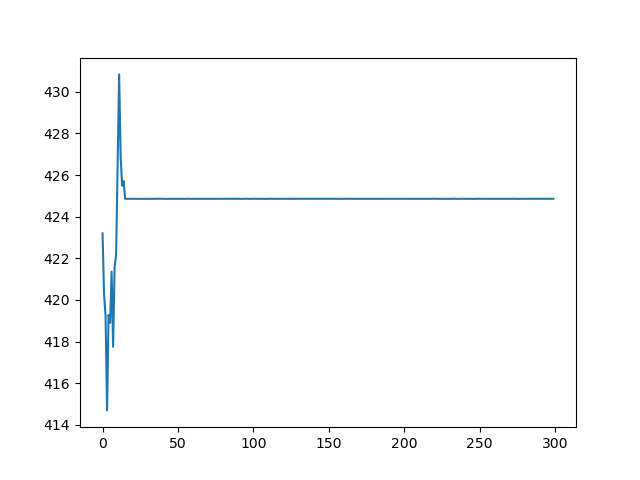

In [42]:
plt.figure()
plt.plot(out_struct['transform_dict']['grades'])

In [34]:
image.dtype

dtype('uint8')

In [29]:
out_name

'D:\\RECTDNN\\processing\\2024-10-11_15-08-46\\\\referencing\\48201C0420M.tif'

In [28]:
corner_arry.shape

(732, 2)